In [ ]:
# !kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset
License(s): unknown




  0%|          | 0.00/121M [00:00<?, ?B/s]
100%|██████████| 121M/121M [00:00<00:00, 1.70GB/s]


In [ ]:
# !unzip /content/face-expression-recognition-dataset.zip

unzip:  cannot find either /content/face-expression-recognition-dataset.zip or /content/face-expression-recognition-dataset.zip.zip.


In [1]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import load_img

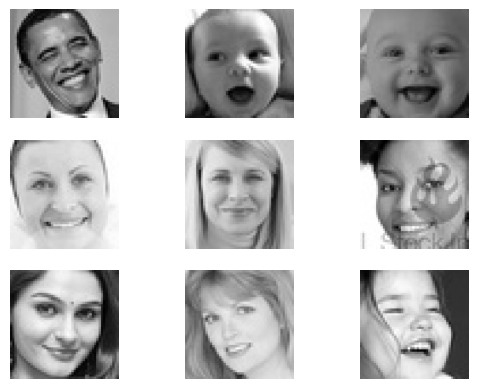

In [2]:
folder_path = r'C:\Users\MAHADEV\OneDrive\Desktop\Zeel\Data Science\Tops\Fair work\Work\Deep Learning\Project\images'
expression = "happy"
picture_size = 224

for i in range(1, 10):
    plt.subplot(3, 3, i)

    folder = os.path.join(folder_path, "train", expression)
    filename = os.listdir(folder)[i]
    img = load_img(os.path.join(folder, filename), target_size=(picture_size, picture_size))

    plt.imshow(img)
    plt.axis('off')

In [3]:
train_path = r'C:\Users\MAHADEV\OneDrive\Desktop\Zeel\Data Science\Tops\Fair work\Work\Deep Learning\Project\images\train'
test_path = r'C:\Users\MAHADEV\OneDrive\Desktop\Zeel\Data Science\Tops\Fair work\Work\Deep Learning\Project\images\validation'

Enable GPU memory growth 

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


In [ ]:
# Configuration
picture_size = 150 # Recommended for ResNet50
batch_size = 32
epochs = 30
no_of_classes = 7


# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_set = train_datagen.flow_from_directory(
    train_path,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=(picture_size, picture_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [6]:
# Load ResNet50 without top layer
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(picture_size, picture_size, 3)
)

In [7]:
# Callbacks
checkpoint = ModelCheckpoint('resnet50_model.h5', monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2,
                              patience=3, min_lr=1e-5, verbose=1)

callbacks_list = [checkpoint, early_stopping, reduce_lr]


In [8]:
from tensorflow.keras.applications import MobileNetV2
# Base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

for layer in base_model.layers[-20:]:
    layer.trainable = True

# Custom head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
# Train the model
history = model.fit(
    train_set,
    steps_per_epoch=len(train_set),
    epochs=epochs,
    validation_data=test_set,
    validation_steps=len(test_set),
    callbacks=callbacks_list
)

Epoch 1/30
901/901 [==============================] - ETA: 0s - loss: 1.7073 - accuracy: 0.3363
Epoch 1: val_accuracy improved from -inf to 0.32706, saving model to resnet50_model.h5
901/901 [==============================] - 467s 503ms/step - loss: 1.7073 - accuracy: 0.3363 - val_loss: 2.4115 - val_accuracy: 0.3271 - lr: 1.0000e-04
Epoch 2/30
901/901 [==============================] - ETA: 0s - loss: 1.3744 - accuracy: 0.4767
Epoch 2: val_accuracy improved from 0.32706 to 0.50000, saving model to resnet50_model.h5
901/901 [==============================] - 94s 104ms/step - loss: 1.3744 - accuracy: 0.4767 - val_loss: 1.3462 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/30
901/901 [==============================] - ETA: 0s - loss: 1.2375 - accuracy: 0.5338
Epoch 3: val_accuracy improved from 0.50000 to 0.51613, saving model to resnet50_model.h5
901/901 [==============================] - 110s 122ms/step - loss: 1.2375 - accuracy: 0.5338 - val_loss: 1.3553 - val_accuracy: 0.5161 - lr: 1

In [10]:
model.save('resnet50_model_new.h5') 